In [ ]:
!pip install jiwer

In [ ]:
import collections
from datetime import datetime
import itertools
import logging
import os
import random

from jiwer import wer, mer
import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFilter
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy import ndimage, signal
import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

# The Problem 

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-configuration). Given the image of a chess board, the configuration of pieces on the board is to be described as a string based on the Forsyth–Edwards Notation ([FEN](https://www.chess.com/terms/fen-chess)) convention

In [ ]:
tf.test.is_gpu_available()

# Non-ML Solution

## Template Matching

### Helper functions

In [ ]:
def show_image(image_id=None, what='train'):
    """Show a random or requested image."""
    if image_id is None:
        all_files = os.listdir(what)
        img_file = random.sample(all_files, 1)[0]
        image_id, _ = os.path.splitext(img_file)
    
    label_df = pd.read_csv(f'{what}.csv')
    img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img = img.resize((256, 256))
    img_np = np.array(img)
    label = label_df[label_df['ImageID'] == int(image_id)].iloc[0, 1]
    return img, img_np, label, image_id

In [ ]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

### Step 1: Determine whether or not a piece is present on a block

Generate a first set of templates.  From training image 0, select black and white pawn pieces, each on black (dark) background and white (light) background. Use these four blocks as templates for subsequent template matching.

Identify whether or not a piece is present on a block using template matching. As explained in the chess pieces template matching solution ([problem 1, approach 2](https://github.com/keyapandia123/ds/blob/main/chess/chess_pieces.ipynb)), select correlation thresholds heuristically:
* Look at the max correlation values for the black and white piece templates when correlated with a background block and with a piece block
* Select a black correlation threshold for discriminating background from a (black) piece when correlating with the black piece template 
* Similarly select a white correlation threshold for discriminating background from a (white) piece when correlating with the white piece template

Selected thresholds are: black = 200 and white = 150

In [ ]:
def return_templates(to_print=False):
    """
    Return templates for black and white pieces.

    Use image 0 to pick out two black pieces (pawns) and two white pieces 
    (pawns) for template-matching. This is the first stage of template-matching 
    to determine whether or not a piece is present in a given block.
    """
    img_template, img_np, label, image_id = show_image(0)
    imgbw_template = img_template.convert(mode='L')
    imgbw_np_template = np.array(imgbw_template)
    
    template_b1 = blockshaped(imgbw_np_template, 32, 32)[8]
    template_b2 = blockshaped(imgbw_np_template, 32, 32)[15]
    template_w1 = blockshaped(imgbw_np_template, 32, 32)[25]
    template_w2 = blockshaped(imgbw_np_template, 32, 32)[35]
    
    if to_print:
        plt.imshow(imgbw_np_template)
        
        fig = plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(template_b1)
        plt.subplot(2,2,2)
        plt.imshow(template_b2)
        plt.subplot(2,2,3)
        plt.imshow(template_w1)
        plt.subplot(2,2,4)
        plt.imshow(template_w2)
            
            
    return template_b1, template_b2, template_w1, template_w2

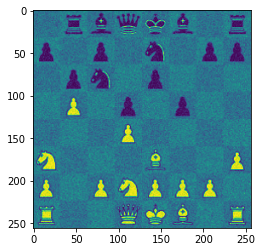

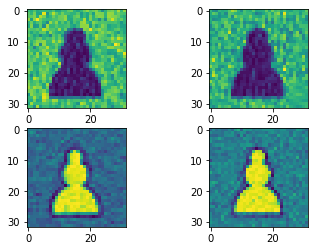

In [ ]:
template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=True)

In [ ]:
def norm_corr(block, template):
    """
    Perform normalized 2D correlation.

    Subtract block mean from block and template mean from template before 
    correlating. Divide correlation output by block standard deviation and 
    template standard deviation.
    """
    return signal.correlate2d(block - np.mean(block), template - np.mean(template)) / (np.std(block) * np.std(template))

Consider training image with id=1

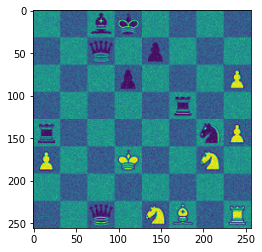

In [ ]:
img, img_np, label, image_id = show_image(1)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)
plt.imshow(imgbw_np)

Consider a white piece from the above image, selected at random. Correlate this white piece with one of the black piece templates and one of the white piece templates. The correlation score with the white piece template exceeds the white correlation threshold (921.275 > 150), hence this white piece block gets detected as a piece.

Correlating a white piece with:
Black template:  243.6733918007919
White template:  921.2757333330021


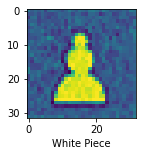

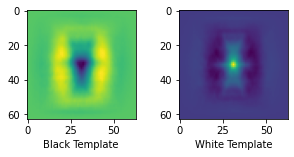

In [ ]:
out1 = norm_corr(blockshaped(imgbw_np, 32, 32)[40], template_b2)
out2 = norm_corr(blockshaped(imgbw_np, 32, 32)[40], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[40])
plt.xlabel('White Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out1)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out2)
plt.xlabel('White Template')

print("Correlating a white piece with:")
print("Black template: ", np.max(out1.flatten()))
print("White template: ", np.max(out2.flatten()))

Consider a black piece from the above image, selected at random. Correlate this black piece with one of the black piece templates and one of the white piece templates. The correlation score with the black piece template exceeds the black correlation threshold (292.992 > 200), hence this black piece block gets detected as a piece.

Correlating a black piece with:
Black template:  292.9926749525346
White template:  211.8840718189504


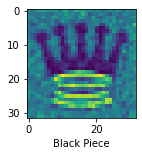

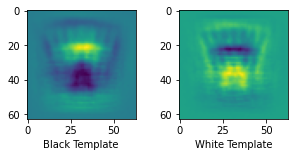

In [ ]:
out3 = norm_corr(blockshaped(imgbw_np, 32, 32)[10], template_b2)
out4 = norm_corr(blockshaped(imgbw_np, 32, 32)[10], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[10])
plt.xlabel('Black Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out3)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out4)
plt.xlabel('White Template')

print("Correlating a black piece with:")
print("Black template: ", np.max(out3.flatten()))
print("White template: ", np.max(out4.flatten()))

Now finally consider a background block from the above image, selected at random. Correlate this block with one of the black piece templates and one of the white piece templates. The correlation score with the neither template exceeds the respective correlation (105.506 < 200 and 83.728 < 150), hence this block gets detected as a background block.

Correlating a background block with:
Black template:  105.50696745831486
White template:  83.72882301641133


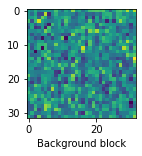

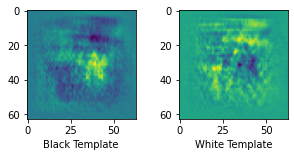

In [ ]:
out5 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_b2)
out6 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[8])
plt.xlabel('Background block')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out5)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out6)
plt.xlabel('White Template')

print("Correlating a background block with:")
print("Black template: ", np.max(out5.flatten()))
print("White template: ", np.max(out6.flatten()))

### Step 2: Determine whether a detected piece is black or white

As explained in the chess pieces template matching solution (problem 1, approach 2), classify a detected piece as black or white
* Use the quantized and blurred image (as explained in problem 1, approach 1) of the block that has a piece 
* Count the number of white pixels vs. the black pixels in the center of the quantized block 
* Classify as black or white piece based on a majority counting heuristic. As shown in the images below, the center of the black bishop piece (after blurring and quantizing) has a majority of black pixels and the center of the white pawn piece (after blurring and quantizing) has a majority of white pixels.

In [ ]:
#Thresholds to go with first quantization step
BLACK_TH1 = 10
WHITE_TH1 = 246

def quantize(imgbw_np):
    """
    Quantize the image into three values for black, white, and background.

    Setting three discrete values for each image pixel. One value for each 
    piece color and the third for the background.
    """
    new_img = imgbw_np.copy()

    new_img[imgbw_np < BLACK_TH1] = 0
    new_img[imgbw_np > WHITE_TH1] = 255
    new_img[(imgbw_np >= BLACK_TH1) & (imgbw_np <= WHITE_TH1)] = 128
    
    return new_img

In [ ]:
#Thresholds to go with second quantization step
BLACK_TH2 = 115
WHITE_TH2 = 135
    

def blur_and_quantize(imgbw_np, img=None, img_np=None):
    """
    Blur quantized image and then quantize the blurred image again.
    Different pixel intensity thresholds are used for the first and second quantization steps. 
    """
    
    new_img1 = imgbw_np.copy()
    new_img = quantize(imgbw_np)
    
    img = Image.fromarray(new_img)
    
    # use blurring
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    imgbw_np = np.array(img_blurred)
    
    new_img[imgbw_np < BLACK_TH2 ] = 0
    new_img[imgbw_np > WHITE_TH2] = 255
    new_img[(imgbw_np >= BLACK_TH2) & (imgbw_np <= WHITE_TH2)] = 128
    
    return new_img

In [ ]:
BL_CORR_TH = 200
WH_CORR_TH = 150

WHITE_TH3 = 9
BLACK_TH3 = 15

def vector_black_white_background_pieces(imgbw_np, new_img, center_only=False):
    """
    Classify each block as B piece, W piece, or background
    
    """
    no_of_blocks = 64
    w = 5
    h = w + 4
    
    x = []
    y = []
    
    template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=False)
    for i in range(no_of_blocks):
        img_block_raw = blockshaped(imgbw_np, 32, 32)[i]
        img_block_quantized = blockshaped(new_img, 32, 32)[i]
        
        # First, detect via correlation (template-matching) whether there is a piece or not in a given block
        out1 = norm_corr(img_block_raw, template_b1)
        out2 = norm_corr(img_block_raw, template_b2)
        out3 = norm_corr(img_block_raw, template_w1)
        out4 = norm_corr(img_block_raw, template_w2)
        
        if np.max(out1.flatten()) < BL_CORR_TH and np.max(out2.flatten()) < BL_CORR_TH and np.max(out3.flatten()) < WH_CORR_TH and np.max(out4.flatten()) < WH_CORR_TH:
            y.append(0.0)  # Background block correlated with none of the four templates will meet the specified threshold
        
        # Second, if piece is present, detect using majority counting hueristic whether the piece is black or white
        else:
            if center_only:
                center = img_block_quantized[16-h:16+h, 16-w:16+w]
                block_dict = collections.Counter(center.flatten())
            else:
                block_dict = collections.Counter(img_block_quantized.flatten())
            
            
            if block_dict[255.0] > WHITE_TH3 or block_dict[255.0] > block_dict[0.0]: 
                y.append(1.0)
                
            elif block_dict[0.0] > BLACK_TH3 and block_dict[0.0] > block_dict[255.0]: 
                y.append(-1.0)
                
            else:
                y.append(0.0)
                
      
    x = np.array(x)
    x = np.expand_dims(x, -1)
    y = np.array(y)
    return x, y

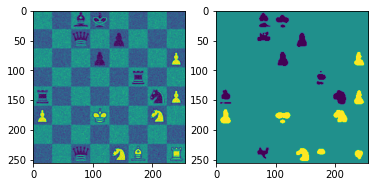

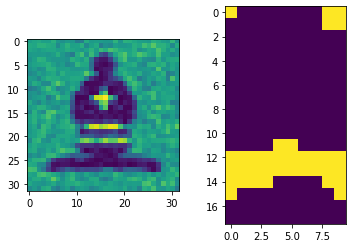

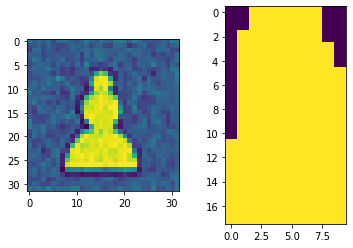

In [ ]:
new_img1 = blur_and_quantize(imgbw_np, img, img_np)
w = 5
h = w + 4
    
plt.subplot(121)
plt.imshow(imgbw_np)
plt.subplot(122)
plt.imshow(new_img1)

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[2])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[2][16-h:16+h, 16-w:16+w])

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[40])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[40][16-h:16+h, 16-w:16+w])


### Step 3: Determine the type of piece, given the piece color

Use a second stage of template matching to identify the type of piece given the color of the piece:

* Generate a second set of templates for black pieces - one for each kind of black piece ('k', 'p', 'n', 'b', 'r', 'q') 
* Generate a third set of templates for white pieces - one for each kind of white piece ('K', 'P', 'N', 'B', 'R', 'Q')
* If a given piece was classified as a black piece, then correlate the piece block with each template from the second set (black templates) to identify the strongest correlation
* If a given piece was classified as a white piece, then correlate the piece block with each template from the third set (white templates) to identify the strongest correlation

In [ ]:
def templates(to_print=False):
    """
    From image 0, select blocks having pieces corresponding to each piece type for each color (B and W)
    Piece types for each color are king, pawn, knight, bishop, rook, and queen
    Return these selected blocks as second and third sets of templates.
    This is the second stage of template-matching to determine the type of piece present in a block.
    
    """
    train_img, img_np, label, image_id = show_image(image_id=0)
    
    imgbw = train_img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    black_templates = []
    black_string = ['k', 'p', 'n', 'b', 'r', 'q']
    black_points = [0, 1, 3, 3, 5, 9]
    white_templates = []
    white_string = ['K', 'P', 'N', 'B', 'R', 'Q']
    white_points = [0, 1, 3, 3, 5, 9]
    
    black_templates.append(img_block[4]) #King
    black_templates.append(img_block[15]) #Pawn
    black_templates.append(img_block[12]) #Knight
    black_templates.append(img_block[2]) #Bishop
    black_templates.append(img_block[1]) #Rook
    black_templates.append(img_block[3]) #Queen
    
    white_templates.append(img_block[60]) #King
    white_templates.append(img_block[48]) #Pawn
    white_templates.append(img_block[40]) #Knight
    white_templates.append(img_block[61]) #Bishop
    white_templates.append(img_block[56]) #Rook
    white_templates.append(img_block[59]) #Queen
    
    if to_print: 
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(black_templates[i-1])
            plt.xlabel(black_string[i-1])
        
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(white_templates[i-1])
            plt.xlabel(white_string[i-1])
    
    return black_templates, black_string, white_templates, white_string

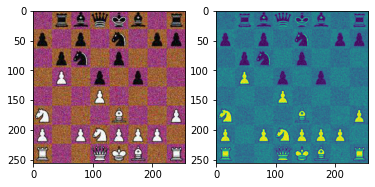

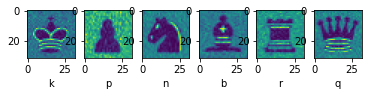

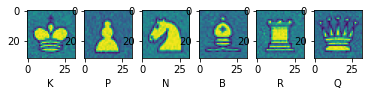

In [ ]:
train_img, img_np, label, image_id = show_image(image_id=0)

imgbw = train_img.convert(mode='L')
imgbw_np = np.array(imgbw)
fig = plt.figure()
plt.subplot(121)
plt.imshow(train_img)
plt.subplot(122)
plt.imshow(imgbw)

black_templates, black_string, white_templates, white_string = templates(to_print=True)

Consider a black bishop piece to be identified

Correlation values:  [309.2906160286696, 518.7549433593449, 450.17709479837663, 903.462056004905, 456.9005143111943, 257.5655463689031]
Identified piece:  b


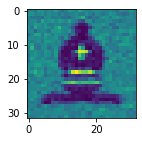

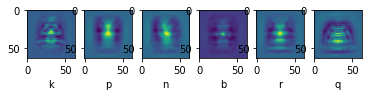

In [ ]:
img_block = blockshaped(imgbw_np, 32, 32)
test_block = img_block[5]
    
fig = plt.figure(figsize=(2, 2))
plt.imshow(test_block)

scores = [] 
fig = plt.figure()
for i in range(1, 7):    
    bt = black_templates[i-1] 
    wt = white_templates[i-1] 
    cor = norm_corr(test_block, bt)
    plt.subplot(1, 6, i)
    plt.imshow(cor)
    plt.xlabel(black_string[i-1])
    scores.append(np.max(np.abs(cor).flatten()))
print('Correlation values: ', scores)
print('Identified piece: ', black_string[np.argmax(np.array(scores))])

Consider a white pawn piece to be identified


Correlation values:  [228.07010089735434, 962.3464453344627, 573.870385278182, 386.5375956755844, 436.1292961314228, 357.91447040703537]
Identified piece:  P


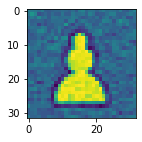

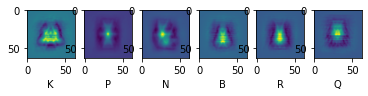

In [ ]:
test_block = img_block[25]
    
fig = plt.figure(figsize=(2, 2))
plt.imshow(test_block)

scores = [] 
fig = plt.figure()
for i in range(1, 7):    
    bt = black_templates[i-1] 
    wt = white_templates[i-1] 
    cor = norm_corr(test_block, wt)
    plt.subplot(1, 6, i)
    plt.imshow(cor)
    plt.xlabel(white_string[i-1])
    scores.append(np.max(np.abs(cor).flatten()))
print('Correlation values: ', scores)
print('Identified piece: ', white_string[np.argmax(np.array(scores))])

### Step 4: Generate configuration string

Generate configuration string by:
* Concatenating the predicted labels for each piece (indicating color and piece type) 
* Counting the number of contiguous background blocks
* End of each row of blocks (except the last row) is represented with a '/'

In [ ]:
def generate_string(im_id=None, to_plot=False):
    """
    Given an image id, generate a configuration string as output for the chess board in the image. 
    Generate a vector of 64 elements indicating whether a block is background or contains a black piece or a white piece.
    Identify the type of piece (k, p, n, b, r, or q) for the identified color.
    Append appropriate label to the configuration string (continuous background squares are indicated by a number).
    """
    img, img_np, label, image_id = show_image(im_id)
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np)
    if to_plot:
        plt.imshow(img)
        fig = plt.figure()
        plt.imshow(new_img1)
    
    new_img2 = quantize(imgbw_np)
    
    img_block = blockshaped(imgbw_np, 32, 32)
      
    _, y = vector_black_white_background_pieces(imgbw_np, new_img1, center_only=True)

    string = []
    black_templates, black_string, white_templates, white_string = templates()
    bg_cnt = 0
    for block in range(64):
        if y[block] == 0.0:  # background block
            bg_cnt += 1
            if ((block < 63) and (y[block + 1] != 0.0)) or (not (block + 1) % 8):
                string.append(str(bg_cnt))
                bg_cnt = 0
            
        scores = []
        if y[block] != 0:  # not background block
            test_block = np.squeeze(img_block[block, :, :])
            
            for i in range(1, 7):
                bt = black_templates[i-1] - np.mean(black_templates[i-1].flatten())
                wt = white_templates[i-1] - np.mean(white_templates[i-1].flatten())
                if y[block] == -1.0:  # if black piece, correlate with black templates
                    cor = norm_corr(test_block, bt)
                    
                elif y[block] == +1.0:  # if white piece, correlate with white templates
                    cor = norm_corr(test_block, wt)
                    
                scores.append(np.max(cor.flatten()))

        
            if y[block] == -1.0:
                string.append(black_string[np.argmax(np.array(scores))])
            elif y[block] == +1.0:
                string.append(white_string[np.argmax(np.array(scores))])
        
        if block < 63 and not (block + 1) % 8:
            string.append('/')
            bg_cnt = 0
                 
    return label, ''.join(string)

True string =  4Bb2/2r1p1p1/2pk2pr/1p1P3p/PpN3PP/2P1P2R/4b3/R1B3K1
Pred string =  4Bb2/2r1p1p1/2pk2pr/1p1P3p/PpN3PP/2P1P2R/4b3/R1B3K1


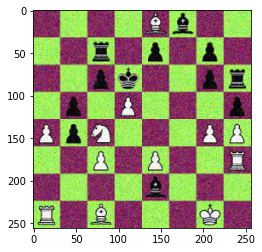

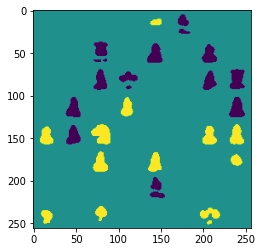

In [ ]:
true, predicted = generate_string(im_id=7, to_plot=True)
print('True string = ', true)
print('Pred string = ', predicted)

### Step 5: Compare the two strings

Compare the true and predicted configuration strings to determine:
* The number of piece matches,
* The number of dropped pieces in the predicted string, 
* Total number of pieces on the board determined from the true string

In [ ]:
def adjusted_compare(true, predicted):
    """
    Function to generate custom comparison scores given two configuration strings (true and predicted)
    """
    def _expand(string):
        adj = []
        for c in string:
            if c == '/':
                continue
            if c.isdigit():
                adj = adj + ['*'] * int(c)
            else:
                adj.append(c)
        return ''.join(adj)
    
    true_adj = _expand(true)
    pred_adj = _expand(predicted)
    
    piece_count = 0
    match_cnt = 0
    dropped_cnt = 0
    
    for t, p in zip(true_adj, pred_adj):
        if t != '*':
            piece_count += 1
            
        if t == p:
            if t != '*':
                match_cnt += 1
        elif p == '*':
            dropped_cnt += 1
    return match_cnt, dropped_cnt, piece_count

In [ ]:
match_cnt, dropped_cnt, piece_count = adjusted_compare(true, predicted)
print('Match Count = ', match_cnt)
print('Dropped Piece Count = ', dropped_cnt)
print('Total Piece Count = ', piece_count)

Match Count =  24
Dropped Piece Count =  0
Total Piece Count =  24


In [ ]:
match_cnt, dropped_cnt, piece_count = adjusted_compare(
    '1r4nb/pB5n/b3pk2/qPB2Np1/3P1PP1/4P3/5K2/3Q3r',
    '1r4nb/pB5n/4pk2/qPB2Np1/3P1PP1/4P3/5K2/7r'
)
print('Match Count = ', match_cnt)
print('Dropped Piece Count = ', dropped_cnt)
print('Total Piece Count = ', piece_count)

Match Count =  19
Dropped Piece Count =  2
Total Piece Count =  21


### Step 6: Repeat over multiple files and generate average accuracy scores

In [ ]:
def avg_accuracy_for_folder(what='train'):
    """
    Compare true and predicted configuration strings over multiple files.
    Generate average accuracy scores across files.
    """
    score = []
    mislabeled = []
    total_match = 0
    total_piece_count = 0
    total_piece_matched = 0
    total_dropped = 0
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 20)

    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = generate_string(im_id)
        
        match_cnt, dropped_cnt, piece_count = adjusted_compare(true, predicted)
        total_piece_count += piece_count
        total_piece_matched += (piece_count - dropped_cnt)
        total_match += match_cnt
        total_dropped += dropped_cnt
        
        error = wer(true, predicted)
        score.append(error)
        if true != predicted:
            mislabeled.append(im_id)
  
    return np.mean(score), total_match / total_piece_matched, total_dropped / total_piece_count, mislabeled

In [ ]:
wer_based, match_frac, dropped_frac, mismatch = avg_accuracy_for_folder(what='train')
print('WER based score (lower the better) = ', wer_based)
print('Matched Piece Fraction = ', match_frac)
print('Dropped Piece Fraction = ', dropped_frac)
print('Mismatched Files: ', mismatch)

WER based score (lower the better) =  0.05
Matched Piece Fraction =  1.0
Dropped Piece Fraction =  0.0022988505747126436
Mismatched Files:  [26069]


### An example of an image where the above approach fails to generate the correct string

True String:  4k1r1/rp6/3pbb1p/pN1P4/P1p1n2p/R3P3/4p2K/5BR1
Pred String:  4k1r1/rp6/3pbb1P/pN1P4/P1p1n2p/R1N1P3/1R2p2K/5BR1


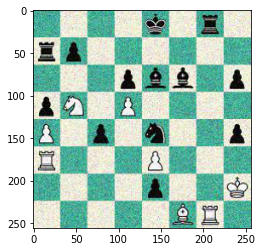

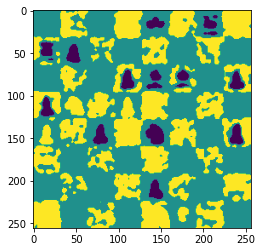

In [ ]:
true, predicted = generate_string(im_id=4195, to_plot=True)

print("True String: ", true)
print("Pred String: ", predicted)

# Using Neural Networks (ML)

### Step 1: Prepare training and validation labels (values of output vector 'y') from the provided configuration string

In [ ]:
def label_to_vector(label):
    def _expand(string):
        adj = []
        for c in string:
            if c == '/':
                continue
            if c.isdigit():
                adj = adj + ['*'] * int(c)
            else:
                adj.append(c)
        return ''.join(adj)
    
    _, black_string, _, white_string = templates()
    
    y = []
    for char in _expand(label):
        if char == '*':
            y.append(0)
        elif char.islower():
            for i in range(6):
                if char == black_string[i]:
                    y.append(i+1)
        else:
            for i in range(6):
                if char == white_string[i]:
                    y.append(i+7)
 
    return y

In [ ]:
_, black_string, _, white_string = templates()
print(black_string)
print(white_string)

['k', 'p', 'n', 'b', 'r', 'q']
['K', 'P', 'N', 'B', 'R', 'Q']


### Step 2: Prepare input data files as provided by a data generator

* Convert an input RGB file into a grayscale image
* Divide / segment the grayscale image into 64 blocks
* Generate 64 batches of image data from each grayscale image (provide each block as a single batch of input)
* Each block of image data corresponds to a value in the 'y' vector produced in Step 1 above.   


In [ ]:
class DataGen(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=64):
        self.what = what
        self.batch_size = 64
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return len(self.all_files)
        
    def __getitem__(self, batch_num):
        
        all_files = self.all_files
        
        file = all_files[batch_num]
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        img, img_np, label, image_id = show_image(im_id, what=self.what)
        img = img.convert('L')

        img_block = blockshaped(np.array(img), 32, 32)
        img_block = np.expand_dims(img_block, -1)
        

        x = img_block / 255.

        y = label_to_vector(label)
        return x, np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen('train', batch_size=64)
val_gen = DataGen('val', batch_size=64)

In [ ]:
train_gen[0][1].shape

(64,)

### Step 3: Build the ML model

In [ ]:
def build_model0():
    inp = keras.Input(shape=(32, 32, 1), name='img')
    
    x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(13, activation='softmax')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model0()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                73760 

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_accuracy'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list, 
                    validation_data=val_gen, 
                    epochs=10,
                    verbose=1,
                    steps_per_epoch=100,
                    validation_steps=10,
                    validation_freq=10)

Epoch 1/10
100/100 [==============================] - 7s 51ms/step - loss: 1.5155 - accuracy: 0.6830
Epoch 2/10
100/100 [==============================] - 5s 51ms/step - loss: 0.1697 - accuracy: 0.9766
Epoch 3/10
100/100 [==============================] - 5s 51ms/step - loss: 0.0249 - accuracy: 0.9965
Epoch 4/10
100/100 [==============================] - 5s 52ms/step - loss: 0.0079 - accuracy: 0.9998
Epoch 5/10
100/100 [==============================] - 5s 52ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 5s 51ms/step - loss: 0.0021 - accuracy: 0.9999
Epoch 7/10
100/100 [==============================] - 5s 51ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 5s 51ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 5s 51ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - 6s 59ms/step - loss: 7.0173e-04 - ac

1.0

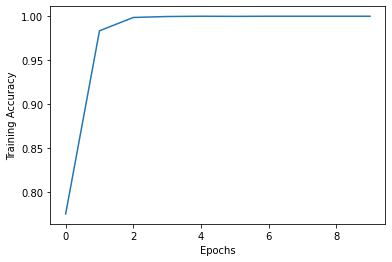

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

### Step 4: Review the weights and activation outputs from the first layer

In [ ]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)
debug_in = train_gen[0][0][3:4]
output = np.squeeze(new_model.predict(debug_in))
output.shape

(30, 30, 32)

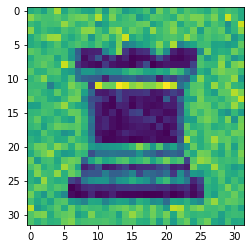

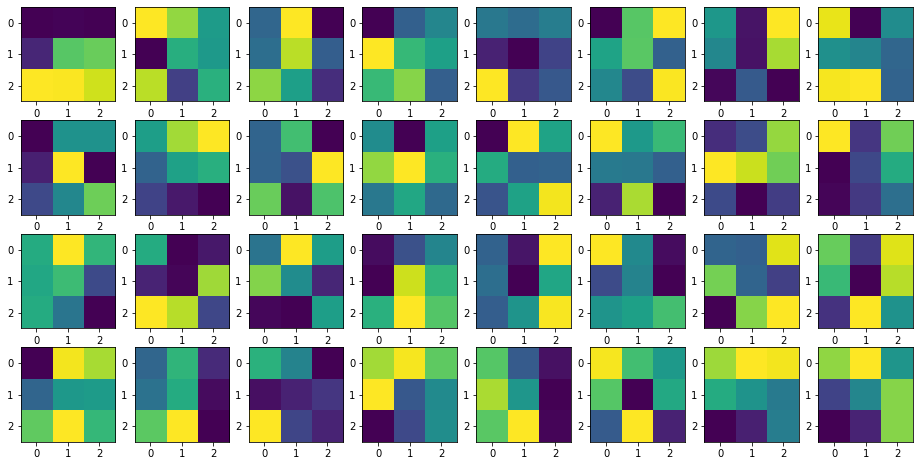

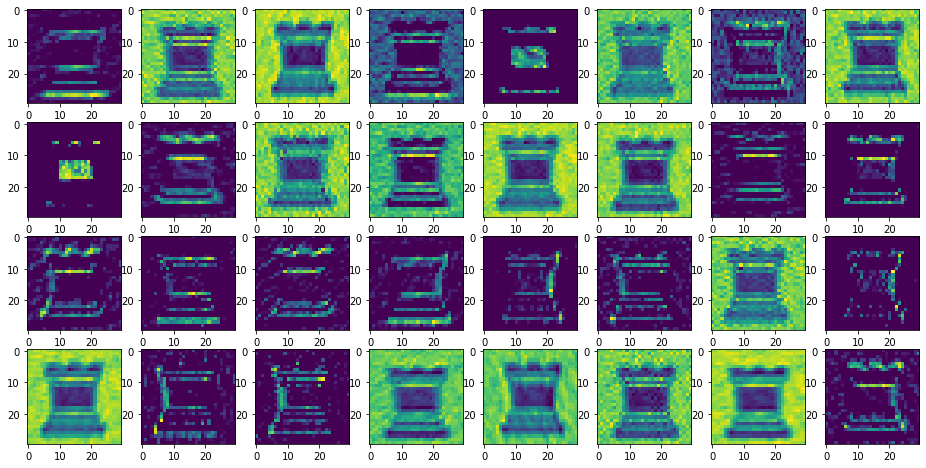

In [ ]:
plt.imshow(np.squeeze(debug_in))


weights = np.squeeze(model.layers[1].get_weights()[0], -2)
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in zip(range(weights.shape[-1]), axes):
    ax.imshow(np.squeeze(weights[:, :, idx]))

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in zip(range(output.shape[-1]), axes):
    ax.imshow(np.squeeze(output[:, :, idx]))

### Step 5: Convert the one-hot encoded output from the ML model into a configuration string

* Run the ML model on the given image
* Convert the one-hot encoded output into a list of predefined ASCII characters (specified as values of the dictionary below). 
* Convert the list of ASCII characters into a predicted configuration string.

In [ ]:
dd = {0:'*', # for background
         1: 'k',
         2: 'p',
         3: 'n',
         4: 'b',
         5: 'r',
         6: 'q',
         7: 'K',
         8: 'P',
         9: 'N',
         10: 'B',
         11: 'R',
         12: 'Q'}

def generate_string2(im_id=None, to_plot=False):
    """
    Given a random or specified image, prodvide the predicted configuration string.
    Run the ML model on the given image, convert the one-hot encoded output into a 
    list of ASCII characters specified as values of the dictionary above. 
    Convert the list of ASCII characters into a predicted configuration string.
    """
    img, img_np, label, image_id = show_image(im_id, what='val')
    img = img.convert('L')
    if to_plot:
        plt.imshow(img)

    img_block = blockshaped(np.array(img), 32, 32)
    img_block = np.expand_dims(img_block, -1)
    x = img_block / 255.

    model = keras.models.load_model('my_model.h5')

    y_pred_one_hot = model.predict(x)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    y_pred_ascii = [dd[x] for x in y_pred]
    
    
    string = []
    bg_cnt = 0
    for block in range(64):
        if y_pred_ascii[block] == '*':  # background block
            bg_cnt += 1
            if ((block < 63) and (y_pred_ascii[block + 1] != '*')) or (not (block + 1) % 8):
                string.append(str(bg_cnt))
                bg_cnt = 0    
        
        if y_pred_ascii[block] != '*':  # not background block
            string.append(y_pred_ascii[block])
        
        if block < 63 and not (block + 1) % 8:
            string.append('/')
            bg_cnt = 0
                 
    return label, ''.join(string)

True string =  4B1n1/4n1p1/pp2k1r1/r4p2/4Pb2/3K2P1/b2p4/5R2
Pred string =  4B1n1/4n1p1/pp2k1r1/r4p2/4Pb2/3K2P1/b2p4/5R2


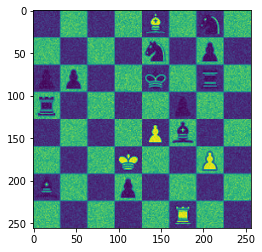

In [ ]:
true, predicted = generate_string2(im_id=None, to_plot=True)
print('True string = ', true)
print('Pred string = ', predicted)

### Step 6: Compare the two strings

As explained above (in Step 5 of the non-ML approach), compare the true and predicted configuration strings to determine:

* The number of piece matches,
* The number of dropped pieces in the predicted string,
* Total number of pieces on the board determined from the true string

In [ ]:
match_cnt, dropped_cnt, piece_count = adjusted_compare(true, predicted)
print('Match Count = ', match_cnt)
print('Dropped Piece Count = ', dropped_cnt)
print('Total Piece Count = ', piece_count)

Match Count =  17
Dropped Piece Count =  0
Total Piece Count =  17


### Step 7: Repeat over multiple files and generate average accuracy scores

In [ ]:
def avg_accuracy_for_folder2(what='val'):
    """
    Compare true and predicted configuration strings over multiple files.
    Generate average accuracy scores across files.
    """
    score = []
    mislabeled = []
    total_match = 0
    total_piece_count = 0
    total_piece_matched = 0
    total_dropped = 0
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 1000)

    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = generate_string2(im_id)
        
        match_cnt, dropped_cnt, piece_count = adjusted_compare(true, predicted)
        total_piece_count += piece_count
        total_piece_matched += (piece_count - dropped_cnt)
        total_match += match_cnt
        total_dropped += dropped_cnt
        
        error = wer(true, predicted)
        score.append(error)
        if true != predicted:
            mislabeled.append(im_id)
  
    return np.mean(score), total_match / total_piece_matched, total_dropped / total_piece_count, mislabeled

In [ ]:
wer_based, match_frac, dropped_frac, mismatch = avg_accuracy_for_folder2(what='val')
print('WER based score (lower the better) = ', wer_based)
print('Matched Piece Fraction = ', match_frac)
print('Dropped Piece Fraction = ', dropped_frac)
print('Mismatched Files: ', mismatch)

WER based score (lower the better) =  0.002
Matched Piece Fraction =  1.0
Dropped Piece Fraction =  8.989572096368213e-05
Mismatched Files:  [3773, 241]
